In [177]:
import json
import modin.pandas as pd
import glob
import sys
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0,'/media/csivsw/crossOS/playground/friends_of_tracking/src/friends_of_tracking/LaurieOnTracking')


In [3]:
import Metrica_IO as mio
import Metrica_Viz as mviz

In [4]:
DATADIR = '../datahub/metrica_sports/sample-data/data/'
game_id = 2

# read in the event data
events = mio.read_event_data(DATADIR,game_id)

# count the number of each event type in the data
print( events['Type'].value_counts() )

PASS              964
CHALLENGE         311
RECOVERY          248
BALL LOST         233
SET PIECE          80
BALL OUT           49
SHOT               24
FAULT RECEIVED     20
CARD                6
Name: Type, dtype: int64


In [6]:
# Bit of housekeeping: unit conversion from metric data units to meters
events = mio.to_metric_coordinates(events)

In [7]:
events.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.00,0.00,-10.60,0.68
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,-7.42,0.00,-6.36,-19.04
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,-3.18,-21.08,-20.14,-14.96
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,-22.26,-12.24,-25.44,5.44


In [18]:
# Get events by team
home_events = events.query("Team=='Home'")
away_events = events.query("Team=='Away'")

home_events.Type.value_counts().to_frame('Home').join(away_events.Type.value_counts().to_frame('Away'))

,Home,Away
PASS,543,421
CHALLENGE,160,151
RECOVERY,135,113
BALL LOST,120,113
SET PIECE,34,46
BALL OUT,27,22
SHOT,13,11
FAULT RECEIVED,9,11
CARD,3,3


In [19]:
# Get all shots
shots = events.query("Type=='SHOT'")
home_shots = home_events.query("Type=='SHOT'")
away_shots = away_events.query("Type=='SHOT'")

home_shots.Subtype.value_counts().to_frame('Home').join(away_shots.Subtype.value_counts().to_frame('Away'))

,Home,Away
HEAD-OFF TARGET-OUT,4,1.0
ON TARGET-SAVED,4,2.0
OFF TARGET-OUT,2,3.0
ON TARGET-GOAL,2,2.0
HEAD-ON TARGET-GOAL,1,NaN


In [21]:
# same as above (shot subtypes -- home vs away)
shots.groupby('Team')['Subtype'].value_counts()

Team  Subtype            
Away  OFF TARGET-OUT         3
      BLOCKED                2
      ON TARGET-GOAL         2
      ON TARGET-SAVED        2
      HEAD-OFF TARGET-OUT    1
      OFF TARGET-HEAD-OUT    1
Home  HEAD-OFF TARGET-OUT    4
      ON TARGET-SAVED        4
      OFF TARGET-OUT         2
      ON TARGET-GOAL         2
      HEAD-ON TARGET-GOAL    1
Name: Subtype, dtype: int64

In [25]:
# Look at the number of shots taken by each player
shots.groupby('Team')['From'].value_counts()

Team  From     
Away  Player19     2
      Player20     2
      Player24     2
      Player 26    1
      Player18     1
      Player21     1
      Player22     1
      Player23     1
Home  Player9      4
      Player10     3
      Player5      2
      Player12     1
      Player3      1
      Player4      1
      Player7      1
Name: From, dtype: int64

In [31]:
# Get the shots that led to a goal
home_goals = home_shots.query("Subtype.str.endswith('GOAL')").copy()
away_goals = away_shots.query("Subtype.str.endswith('GOAL')").copy()

# Add a column event 'Minute' to the data frame
home_goals['Minute'] = home_goals['Start Time [s]']/60.

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1e66980860>)

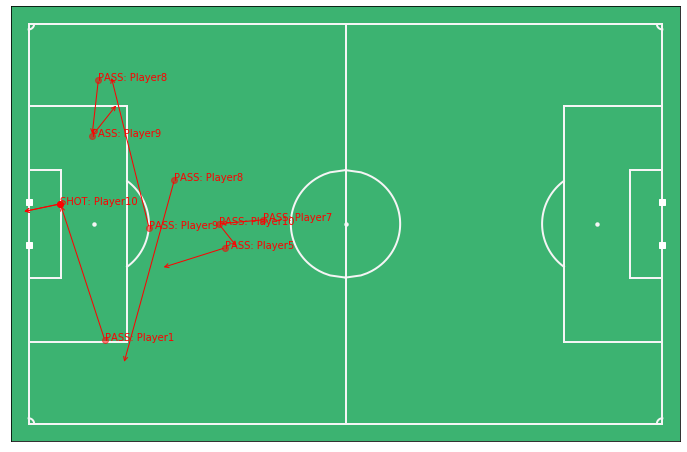

In [39]:
# Plot the first goal
fig,ax = mviz.plot_pitch()
ax.plot( events.loc[198]['Start X'], events.loc[198]['Start Y'], 'ro' )
ax.annotate("", xy=events.loc[198][['End X','End Y']], 
            xytext=events.loc[198][['Start X','Start Y']], 
            alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'));

# plot passing move in run up to goal
mviz.plot_events(events.loc[190:198], indicators = ['Marker','Arrow'], 
                 annotate=True, figax=(fig,ax))

# Tracking data

In [41]:
# READING IN TRACKING DATA
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

# Look at the column namems
print( tracking_home.columns )

Reading team: home
Reading team: away
Index(['Period', 'Time [s]', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')


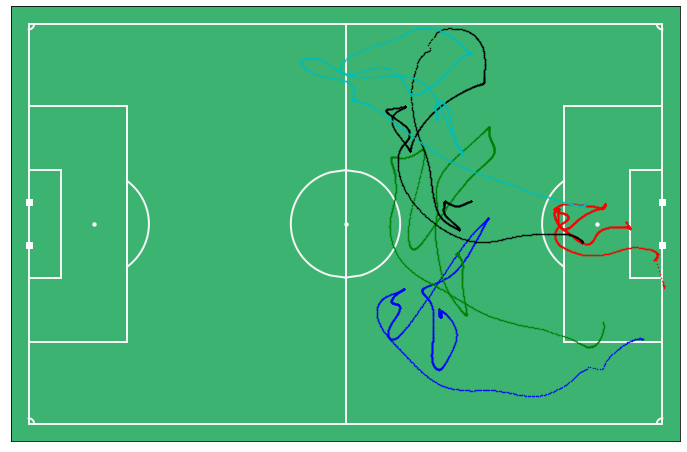

In [42]:
# Plot some player trajectories (players 11,1,2,3,4)
fig,ax = mviz.plot_pitch()
ax.plot( tracking_home['Home_11_x'].iloc[:1500], tracking_home['Home_11_y'].iloc[:1500], 'r.', MarkerSize=1)
ax.plot( tracking_home['Home_1_x'].iloc[:1500], tracking_home['Home_1_y'].iloc[:1500], 'b.', MarkerSize=1)
ax.plot( tracking_home['Home_2_x'].iloc[:1500], tracking_home['Home_2_y'].iloc[:1500], 'g.', MarkerSize=1)
ax.plot( tracking_home['Home_3_x'].iloc[:1500], tracking_home['Home_3_y'].iloc[:1500], 'k.', MarkerSize=1)
ax.plot( tracking_home['Home_4_x'].iloc[:1500], tracking_home['Home_4_y'].iloc[:1500], 'c.', MarkerSize=1)


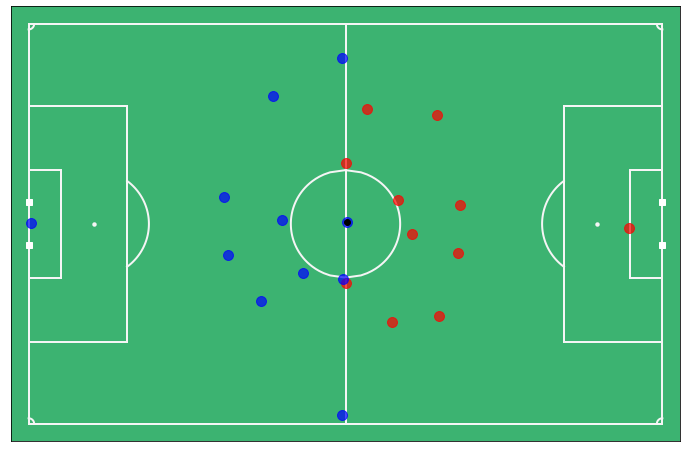

In [43]:
# plot player positions at ,atckick-off
KO_Frame = events.loc[0]['Start Frame']
fig,ax = mviz.plot_frame( tracking_home.loc[KO_Frame], tracking_away.loc[KO_Frame] )


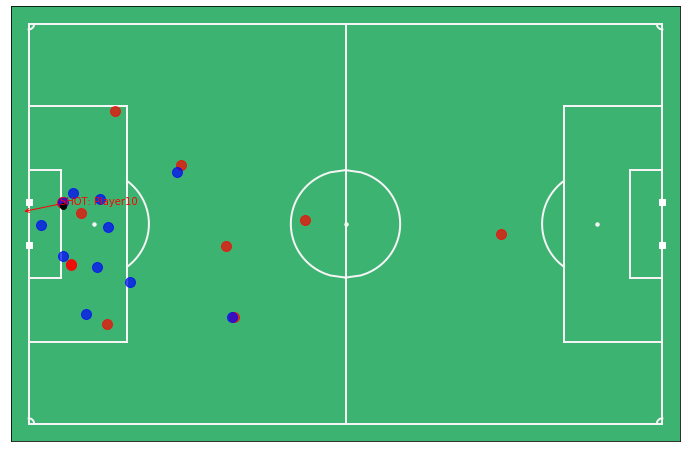

In [44]:
# PLOT POISTIONS AT GOAL
fig,ax = mviz.plot_events( events.loc[198:198], indicators = ['Marker','Arrow'], annotate=True )
goal_frame = events.loc[198]['Start Frame']
fig,ax = mviz.plot_frame( tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax = (fig,ax) )


# Homework

## Plot the passes and shot leading up to the second and third goals in the match

In [82]:
def get_goal_lead_up(goal_id,events):
    for i,row in events.iloc[goal_id-1::-1,:2].iterrows():
        if row['Type']!='PASS':
            break
    return events.iloc[i+1:goal_id+1,:]

events.query("Type=='SHOT' & Subtype.str.endswith('GOAL')")

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
198,Home,SHOT,ON TARGET-GOAL,1,12202,488.08,12212,488.48,Player10,NaN,-47.70,3.40,-54.06,2.04
823,Away,SHOT,ON TARGET-GOAL,1,53049,2121.96,53075,2123.00,Player24,NaN,44.52,-2.72,54.06,-1.36
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.80,Player9,NaN,47.70,1.36,54.06,2.04
1671,Away,SHOT,ON TARGET-GOAL,2,115009,4600.36,115024,4600.96,Player20,NaN,-40.28,1.36,-55.12,2.72
1723,Home,SHOT,ON TARGET-GOAL,2,121027,4841.08,121055,4842.20,Player12,NaN,30.74,5.44,54.06,2.72


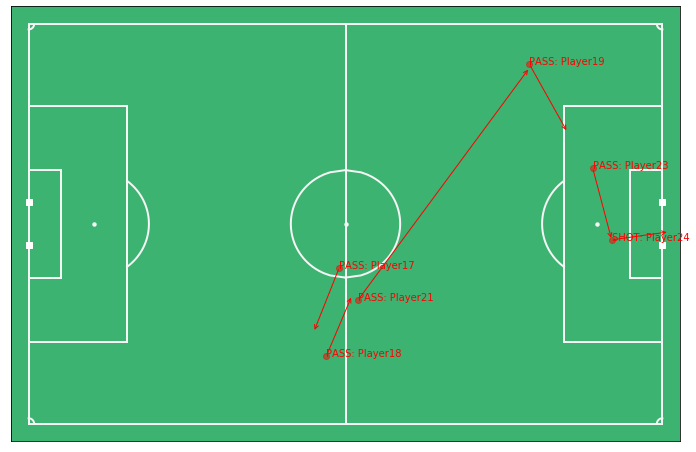

In [89]:
# PLOT POISTIONS AT GOAL
goal_events = get_goal_lead_up(823,events)
fig,ax = mviz.plot_events(events.loc[i+1:823], indicators = ['Marker','Arrow'], annotate=True )
# goal_frame = events.loc[823]['Start Frame']
# fig,ax = mviz.plot_frame( tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax = (fig,ax) )


## Third goal

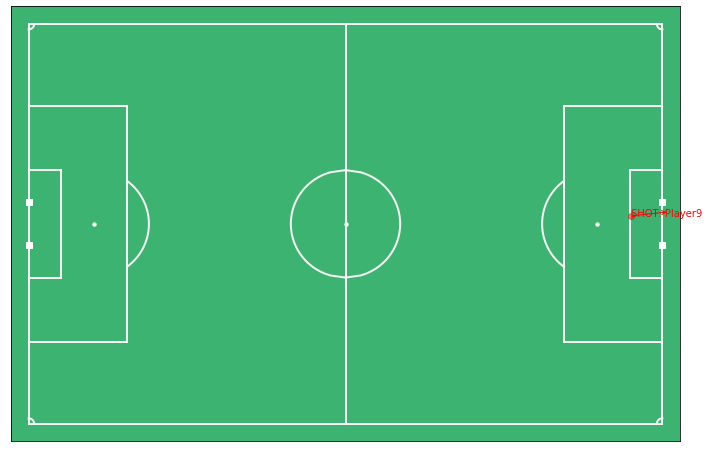

In [90]:
# PLOT POISTIONS AT GOAL
goal_events = get_goal_lead_up(1118,events)
fig,ax = mviz.plot_events(goal_events, indicators = ['Marker','Arrow'], annotate=True )
# goal_frame = events.loc[823]['Start Frame']
# fig,ax = mviz.plot_frame( tracking_home.loc[goal_frame], tracking_away.loc[goal_frame], figax = (fig,ax) )


## Player 9 of home team

In [91]:
events.query("Type=='SHOT' & From=='Player9'")

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1118,Home,SHOT,HEAD-ON TARGET-GOAL,2,73983,2959.32,73995,2959.8,Player9,NaN,47.70,1.36,54.06,2.04
1681,Home,SHOT,HEAD-OFF TARGET-OUT,2,117218,4688.72,117245,4689.8,Player9,NaN,41.34,7.48,54.06,-5.44
1756,Home,SHOT,HEAD-OFF TARGET-OUT,2,124336,4973.44,124365,4974.6,Player9,NaN,45.58,0.00,55.12,7.48
1927,Home,SHOT,ON TARGET-SAVED,2,139891,5595.64,139925,5597.0,Player9,NaN,21.20,1.36,50.88,1.36


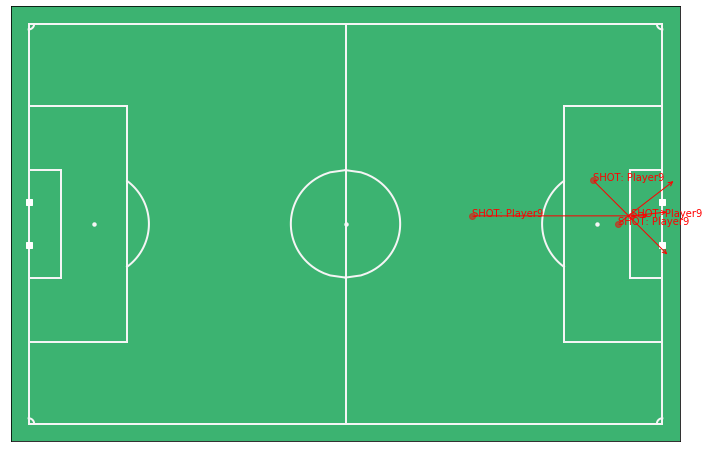

In [92]:
fig,ax = mviz.plot_events(events.query("Type=='SHOT' & From=='Player9'"), indicators = ['Marker','Arrow'], annotate=True )

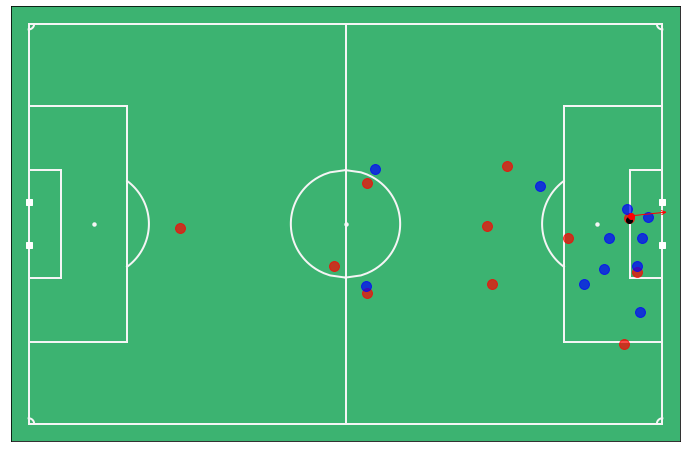

In [107]:
fig,ax = mviz.plot_pitch()

for i , row in events.query("Type=='SHOT' & From=='Player9'").iterrows():
    if row['Subtype'].endswith('GOAL'):
        alpha = 0.6
        style = 'ro'
        color = 'red'
        goal_frame = row['Start Frame']
        fig,ax = mviz.plot_frame( tracking_home.loc[goal_frame], 
                                 tracking_away.loc[goal_frame], figax = (fig,ax) )

#     else:
#         alpha = 0.9
#         style = 'bo'
#         color = 'cyan'
        ax.plot( row['Start X'], row['Start Y'], style )
        ax.annotate("", xy=row[['End X','End Y']], 
                    xytext=row[['Start X','Start Y']], 
                    alpha=alpha, arrowprops=dict(arrowstyle="->",color=color));

# how far each player ran

In [139]:
tracking_home.head()

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,46.9315,0.28084,15.70072,-14.5486,18.81712,-4.89396,21.07492,3.81208,...,0.20564,7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,46.9315,0.28084,15.70072,-14.5486,18.81712,-4.89396,21.07492,3.81208,...,0.20564,7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,46.9315,0.28084,15.70072,-14.5486,18.81712,-4.89396,21.07492,3.81208,...,0.20564,7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,46.9315,0.28084,15.70072,-14.5486,18.81712,-4.89396,21.07492,3.81208,...,0.20564,7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,46.9315,0.28084,15.70072,-14.5486,18.81712,-4.89396,21.07492,3.81208,...,0.20564,7.56364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
tracking_home_dists = tracking_home.diff()
tracking_home_dists.iloc[:,:2] = tracking_home.iloc[:,:2]
for i in range(1,12):
    tracking_home_dists['Home_{}_d'.format(i)] = np.sqrt((tracking_home_dists['Home_{}_x'.format(i)] ** 2)+\
                                             (tracking_home_dists['Home_{}_y'.format(i)] ** 2))
    
# tracking_home_dists.iloc[:,-11:].sum()
home_dist = tracking_home_dists.iloc[:,-11:].rolling(25).mean().sum().to_frame('d')

scaler = MinMaxScaler()
home_dist['d_norm'] = scaler.fit_transform(home_dist)
home_dist

,d,d_norm
Home_1_d,10435.707743,0.738957
Home_2_d,9991.684623,0.674713
Home_3_d,9631.094747,0.622541
Home_4_d,7320.752609,0.288268
Home_5_d,12239.919898,1.000000
Home_6_d,11607.392810,0.908483
Home_7_d,11296.546697,0.863508
Home_8_d,9111.801479,0.547407
Home_9_d,9852.773047,0.654615
Home_10_d,9095.773269,0.545088


In [208]:
tracking_away_dists = tracking_away.diff()
tracking_away_dists.iloc[:,:2] = tracking_away.iloc[:,:2]
for i in range(15,26):
    tracking_away_dists['Away_{}_d'.format(i)] = np.sqrt((tracking_away_dists['Away_{}_x'.format(i)] ** 2)+\
                                             (tracking_away_dists['Away_{}_y'.format(i)] ** 2))
    
# tracking_away_dists.iloc[:,-11:].sum()
away_dist = tracking_away_dists.iloc[:,-11:].rolling(25).mean().sum().to_frame('d')

scaler = MinMaxScaler()
away_dist['d_norm'] = scaler.fit_transform(away_dist)
away_dist

,d,d_norm
Away_15_d,10327.552231,0.878145
Away_16_d,9600.325163,0.781538
Away_17_d,9404.392549,0.755510
Away_18_d,10468.474947,0.896866
Away_19_d,11244.835552,1.000000
Away_20_d,10979.415709,0.964741
Away_21_d,10069.620611,0.843881
Away_22_d,6416.758517,0.358623
Away_23_d,9736.236143,0.799593
Away_24_d,9967.092460,0.830261


In [209]:
home_data = tracking_home.loc[KO_Frame].append(home_dist.d_norm).dropna()
away_data = tracking_away.loc[KO_Frame].append(away_dist.d_norm).dropna()

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1e43e85320>)

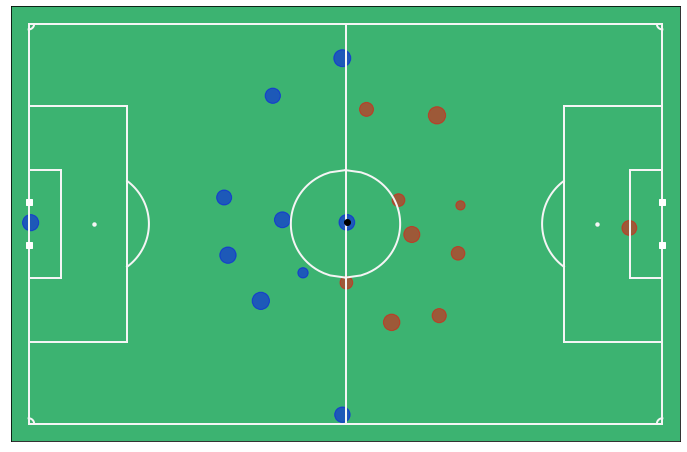

In [216]:

def plot_frame( hometeam, awayteam, figax=None, 
               team_colors=('r','b'), 
               field_dimen = (106.0,68.0), 
               include_player_velocities=False, 
               PlayerMarkerSize=10, PlayerAlpha=0.5 ):
    """ plot_frame( hometeam, awayteam )
    
    Plots a frame of Metrica tracking data (player positions and the ball) on a football pitch. All distances should be in meters.
    
    Parameters
    -----------
        hometeam: row (i.e. instant) of the home team tracking data frame
        awayteam: row of the away team tracking data frame
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot, 
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    if figax is None: # create new pitch 
        fig,ax = mviz.plot_pitch( field_dimen = field_dimen )
    else: # overlay on a previously generated pitch
        fig,ax = figax # unpack tuple
    # plot home & away teams in order
    for team,color in zip( [hometeam,awayteam], team_colors) :
        x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
        y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
        d_columns = [c for c in team.keys() if '_d' in c]
        
        ax.scatter(team[x_columns], team[y_columns], 
                c=[color for x in range(11)], 
                s=list(team[d_columns]*300), 
                alpha=PlayerAlpha)
#         print (team[d_columns].values)
#         ax.plot( team[x_columns], team[y_columns], 
#                 color+'o', 
#                 MarkerSize=list(team[d_columns]), 
#                 alpha=PlayerAlpha ) # plot player positions
        if include_player_velocities:
            vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
            vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
            ax.quiver( team[x_columns], team[y_columns], 
                      team[vx_columns], team[vy_columns], 
                      color=color, scale_units='inches', scale=10.,
                      width=0.002,headlength=5,headwidth=3,)
    # plot ball
    ax.plot( hometeam['ball_x'], hometeam['ball_y'], 'ko', MarkerSize=6, alpha=1.0, LineWidth=0)
    return fig,ax

plot_frame(home_data,away_data)

In [219]:
home_dist

,d,d_norm
Home_1_d,10435.707743,0.738957
Home_2_d,9991.684623,0.674713
Home_3_d,9631.094747,0.622541
Home_4_d,7320.752609,0.288268
Home_5_d,12239.919898,1.000000
Home_6_d,11607.392810,0.908483
Home_7_d,11296.546697,0.863508
Home_8_d,9111.801479,0.547407
Home_9_d,9852.773047,0.654615
Home_10_d,9095.773269,0.545088


In [220]:
away_dist

,d,d_norm
Away_15_d,10327.552231,0.878145
Away_16_d,9600.325163,0.781538
Away_17_d,9404.392549,0.755510
Away_18_d,10468.474947,0.896866
Away_19_d,11244.835552,1.000000
Away_20_d,10979.415709,0.964741
Away_21_d,10069.620611,0.843881
Away_22_d,6416.758517,0.358623
Away_23_d,9736.236143,0.799593
Away_24_d,9967.092460,0.830261
